# v20 SPLADE-v3 Model Test

This notebook tests the **naver/splade-v3** model with Korean sentence data from KLUE dataset.

## SPLADE-v3 Overview

- **Model**: naver/splade-v3
- **Type**: Sparse Encoder (learned sparse retrieval)
- **Base**: BERT with MLM head
- **Output**: 30,522 dimensional sparse vectors
- **Performance**: MRR@10 40.2 (MS MARCO), nDCG@10 51.7 (BEIR-13)

## Test Data

- **Dataset**: KLUE-STS (Korean Language Understanding Evaluation - Semantic Textual Similarity)
- **Source**: https://huggingface.co/datasets/klue
- **Format**: Korean sentence pairs with similarity labels

In [1]:
import sys
from pathlib import Path

def find_project_root():
    """Find project root by looking for markers."""
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm.notebook import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True
GPU: NVIDIA GB10


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


## 1. Load SPLADE-v3 Model

In [3]:
from src.model.splade_v3 import SPLADEv3, load_splade_v3

# Load SPLADE-v3 model
model = load_splade_v3("naver/splade-v3")

print(f"\nModel loaded successfully!")
print(f"Vocabulary size: {model.vocab_size:,}")

Loading SPLADE-v3 from naver/splade-v3...
Model loaded on cuda

Model loaded successfully!
Vocabulary size: 30,522


## 2. Load KLUE-STS Dataset

KLUE-STS contains Korean sentence pairs with semantic similarity scores (0-5).

In [4]:
# Load KLUE-STS dataset
print("Loading KLUE-STS dataset...")
dataset = load_dataset("klue", "sts", trust_remote_code=True)

print(f"\nDataset loaded!")
print(f"Train: {len(dataset['train']):,} samples")
print(f"Validation: {len(dataset['validation']):,} samples")

print(f"\nColumns: {dataset['train'].column_names}")
print(f"\nSample:")
sample = dataset['validation'][0]
print(f"  Sentence 1: {sample['sentence1']}")
print(f"  Sentence 2: {sample['sentence2']}")
print(f"  Label: {sample['labels']['label']:.2f}")

Loading KLUE-STS dataset...

Dataset loaded!
Train: 11,668 samples
Validation: 519 samples

Columns: ['guid', 'source', 'sentence1', 'sentence2', 'labels']

Sample:
  Sentence 1: 무엇보다도 호스트분들이 너무 친절하셨습니다.
  Sentence 2: 무엇보다도, 호스트들은 매우 친절했습니다.
  Label: 4.90


In [5]:
# Extract sample sentences for testing
test_sentences = []
test_pairs = []

for i, sample in enumerate(dataset['validation']):
    if i >= 100:  # Limit to 100 pairs for testing
        break
    test_sentences.append(sample['sentence1'])
    test_sentences.append(sample['sentence2'])
    test_pairs.append({
        's1': sample['sentence1'],
        's2': sample['sentence2'],
        'label': sample['labels']['label'],
    })

# Remove duplicates while preserving order
seen = set()
unique_sentences = []
for s in test_sentences:
    if s not in seen:
        seen.add(s)
        unique_sentences.append(s)

print(f"Unique sentences: {len(unique_sentences)}")
print(f"Test pairs: {len(test_pairs)}")

print(f"\nSample sentences:")
for s in unique_sentences[:5]:
    print(f"  - {s}")

Unique sentences: 200
Test pairs: 100

Sample sentences:
  - 무엇보다도 호스트분들이 너무 친절하셨습니다.
  - 무엇보다도, 호스트들은 매우 친절했습니다.
  - 주요 관광지 모두 걸어서 이동가능합니다.
  - 위치는 피렌체 중심가까지 걸어서 이동 가능합니다.
  - 학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018학년도 수능부터 도입된 영어 영역 절대평가는 올해도 유지한다.


## 3. Analyze Korean Sentence Representations

In [6]:
# Analyze sample Korean sentences
print("=" * 80)
print("KOREAN SENTENCE ANALYSIS WITH SPLADE-v3")
print("=" * 80)

sample_sentences = [
    "검색 엔진은 인터넷에서 정보를 찾는 도구입니다.",
    "인공지능은 기계가 인간처럼 학습하고 사고하는 기술입니다.",
    "머신러닝은 데이터로부터 패턴을 학습하는 인공지능의 한 분야입니다.",
    "자연어처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다.",
    "무엇보다도 호스트분들이 너무 친절하셨습니다.",
]

for sentence in sample_sentences:
    print(f"\n{'='*60}")
    print(f"Input: {sentence}")
    print(f"{'='*60}")
    
    # Analyze as document
    analysis = model.analyze_text(sentence, is_query=False, top_k=15)
    
    print(f"Non-zero tokens: {analysis['nonzero_count']}")
    print(f"Sparsity: {analysis['sparsity']:.4f}")
    print(f"Max weight: {analysis['max_weight']:.4f}")
    print(f"Mean weight: {analysis['mean_weight']:.4f}")
    
    print(f"\nTop tokens:")
    for i, (token, weight) in enumerate(analysis['top_tokens'][:10]):
        print(f"  {i+1:2}. {token:20} {weight:.4f}")

KOREAN SENTENCE ANALYSIS WITH SPLADE-v3

Input: 검색 엔진은 인터넷에서 정보를 찾는 도구입니다.
Non-zero tokens: 217
Sparsity: 0.9929
Max weight: 1.8323
Mean weight: 0.5486

Top tokens:
   1. korea                1.8323
   2. ##ᄌ                  1.8231
   3. song                 1.7155
   4. ##ᄉ                  1.6425
   5. ##ᅢ                  1.5795
   6. korean               1.5425
   7. .                    1.4464
   8. ##ᆸ                  1.3920
   9. ##ᄇ                  1.3542
  10. g                    1.3268

Input: 인공지능은 기계가 인간처럼 학습하고 사고하는 기술입니다.
Non-zero tokens: 442
Sparsity: 0.9855
Max weight: 1.9183
Mean weight: 0.5134

Top tokens:
   1. korea                1.9183
   2. ##u                  1.7432
   3. song                 1.7303
   4. ##ᄌ                  1.6862
   5. korean               1.5642
   6. ##ᄀ                  1.5478
   7. ᄋ                    1.5383
   8. university           1.4939
   9. ##ᄎ                  1.4924
  10. ##ᄃ                  1.4098

Input: 머신러닝은 데이터로부터 패턴을 

## 4. Query-Document Similarity Test

In [7]:
# Test query-document similarity
print("=" * 80)
print("QUERY-DOCUMENT SIMILARITY TEST")
print("=" * 80)

queries = [
    "검색 엔진이란 무엇인가?",
    "인공지능의 정의는?",
    "머신러닝과 딥러닝의 차이점",
]

documents = [
    "검색 엔진은 인터넷에서 정보를 찾는 도구입니다.",
    "인공지능은 기계가 인간처럼 학습하고 사고하는 기술입니다.",
    "머신러닝은 데이터로부터 패턴을 학습하는 인공지능의 한 분야입니다.",
    "딥러닝은 여러 층의 신경망을 사용하는 머신러닝 기법입니다.",
    "자연어처리는 컴퓨터가 인간의 언어를 이해하는 기술입니다.",
]

# Encode
print("\nEncoding queries and documents...")
query_emb = model.encode_query(queries, return_sparse=False)
doc_emb = model.encode_document(documents, return_sparse=False)

# Calculate similarity
similarities = model.similarity(query_emb, doc_emb)

print(f"\nQuery embeddings shape: {query_emb.shape}")
print(f"Document embeddings shape: {doc_emb.shape}")
print(f"Similarity matrix shape: {similarities.shape}")

# Display results
print(f"\n{'='*80}")
print("SIMILARITY MATRIX")
print(f"{'='*80}")

for i, query in enumerate(queries):
    print(f"\nQuery: {query}")
    print("-" * 60)
    
    # Sort documents by similarity
    scores = similarities[i].tolist()
    ranked = sorted(enumerate(scores), key=lambda x: -x[1])
    
    for rank, (doc_idx, score) in enumerate(ranked):
        print(f"  {rank+1}. [{score:.4f}] {documents[doc_idx][:50]}...")

QUERY-DOCUMENT SIMILARITY TEST

Encoding queries and documents...

Query embeddings shape: torch.Size([3, 30522])
Document embeddings shape: torch.Size([5, 30522])
Similarity matrix shape: torch.Size([3, 5])

SIMILARITY MATRIX

Query: 검색 엔진이란 무엇인가?
------------------------------------------------------------
  1. [20.1714] 검색 엔진은 인터넷에서 정보를 찾는 도구입니다....
  2. [16.1123] 인공지능은 기계가 인간처럼 학습하고 사고하는 기술입니다....
  3. [15.8241] 머신러닝은 데이터로부터 패턴을 학습하는 인공지능의 한 분야입니다....
  4. [13.5156] 자연어처리는 컴퓨터가 인간의 언어를 이해하는 기술입니다....
  5. [13.0787] 딥러닝은 여러 층의 신경망을 사용하는 머신러닝 기법입니다....

Query: 인공지능의 정의는?
------------------------------------------------------------
  1. [14.2520] 인공지능은 기계가 인간처럼 학습하고 사고하는 기술입니다....
  2. [14.0156] 검색 엔진은 인터넷에서 정보를 찾는 도구입니다....
  3. [12.6538] 머신러닝은 데이터로부터 패턴을 학습하는 인공지능의 한 분야입니다....
  4. [12.5068] 딥러닝은 여러 층의 신경망을 사용하는 머신러닝 기법입니다....
  5. [11.9580] 자연어처리는 컴퓨터가 인간의 언어를 이해하는 기술입니다....

Query: 머신러닝과 딥러닝의 차이점
------------------------------------------------------------
  1. [42.3281] 딥러닝은 여러 층

## 5. KLUE-STS Correlation Analysis

Evaluate how well SPLADE-v3 similarity correlates with human similarity labels.

In [8]:
from scipy.stats import pearsonr, spearmanr

print("Evaluating on KLUE-STS validation set...")

# Collect all sentence pairs
s1_list = [p['s1'] for p in test_pairs]
s2_list = [p['s2'] for p in test_pairs]
labels = [p['label'] for p in test_pairs]

# Encode all sentences
print(f"Encoding {len(s1_list)} sentence pairs...")
s1_emb = model.encode_document(s1_list, return_sparse=False)
s2_emb = model.encode_document(s2_list, return_sparse=False)

# Calculate pairwise similarities
pred_scores = []
for i in tqdm(range(len(s1_list)), desc="Computing similarities"):
    score = (s1_emb[i] * s2_emb[i]).sum().item()  # Dot product
    pred_scores.append(score)

# Calculate correlations
pearson_corr, pearson_p = pearsonr(pred_scores, labels)
spearman_corr, spearman_p = spearmanr(pred_scores, labels)

print(f"\n{'='*60}")
print("KLUE-STS EVALUATION RESULTS")
print(f"{'='*60}")
print(f"Samples: {len(test_pairs)}")
print(f"Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.2e})")
print(f"Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")

Evaluating on KLUE-STS validation set...
Encoding 100 sentence pairs...


Computing similarities:   0%|          | 0/100 [00:00<?, ?it/s]


KLUE-STS EVALUATION RESULTS
Samples: 100
Pearson correlation: -0.1005 (p=3.20e-01)
Spearman correlation: -0.1363 (p=1.76e-01)


/tmp/ipykernel_37648/2310035808.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(bin_scores, labels=bin_labels)


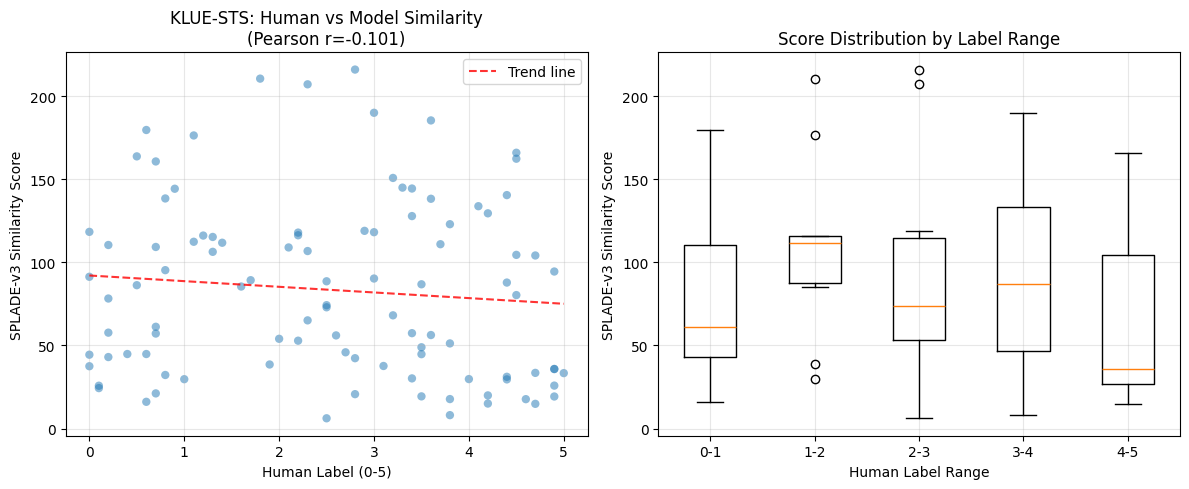

In [9]:
# Visualize correlation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(labels, pred_scores, alpha=0.5, edgecolors='none')
ax1.set_xlabel('Human Label (0-5)')
ax1.set_ylabel('SPLADE-v3 Similarity Score')
ax1.set_title(f'KLUE-STS: Human vs Model Similarity\n(Pearson r={pearson_corr:.3f})')

# Add trend line
z = np.polyfit(labels, pred_scores, 1)
p = np.poly1d(z)
x_line = np.linspace(min(labels), max(labels), 100)
ax1.plot(x_line, p(x_line), 'r--', alpha=0.8, label='Trend line')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribution of scores by label range
ax2 = axes[1]
label_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
bin_scores = []
bin_labels = []

for low, high in label_bins:
    bin_mask = [(low <= l < high) for l in labels]
    scores = [s for s, m in zip(pred_scores, bin_mask) if m]
    if scores:
        bin_scores.append(scores)
        bin_labels.append(f'{low}-{high}')

ax2.boxplot(bin_scores, labels=bin_labels)
ax2.set_xlabel('Human Label Range')
ax2.set_ylabel('SPLADE-v3 Similarity Score')
ax2.set_title('Score Distribution by Label Range')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sparsity Analysis

In [10]:
# Analyze sparsity patterns
print("Analyzing sparsity patterns...")

nonzero_counts = []
max_weights = []
mean_weights = []

for sent in tqdm(unique_sentences[:50], desc="Analyzing"):
    analysis = model.analyze_text(sent, is_query=False)
    nonzero_counts.append(analysis['nonzero_count'])
    max_weights.append(analysis['max_weight'])
    mean_weights.append(analysis['mean_weight'])

print(f"\n{'='*60}")
print("SPARSITY STATISTICS")
print(f"{'='*60}")
print(f"Non-zero tokens per sentence:")
print(f"  Min: {min(nonzero_counts)}")
print(f"  Max: {max(nonzero_counts)}")
print(f"  Mean: {np.mean(nonzero_counts):.1f}")
print(f"  Std: {np.std(nonzero_counts):.1f}")
print(f"\nAverage sparsity: {1 - np.mean(nonzero_counts) / 30522:.6f}")
print(f"\nMax weights: min={min(max_weights):.3f}, max={max(max_weights):.3f}, mean={np.mean(max_weights):.3f}")
print(f"Mean weights: min={min(mean_weights):.3f}, max={max(mean_weights):.3f}, mean={np.mean(mean_weights):.3f}")

Analyzing sparsity patterns...


Analyzing:   0%|          | 0/50 [00:00<?, ?it/s]


SPARSITY STATISTICS
Non-zero tokens per sentence:
  Min: 29
  Max: 467
  Mean: 264.5
  Std: 112.1

Average sparsity: 0.991333

Max weights: min=1.269, max=2.636, mean=1.910
Mean weights: min=0.397, max=0.587, mean=0.517


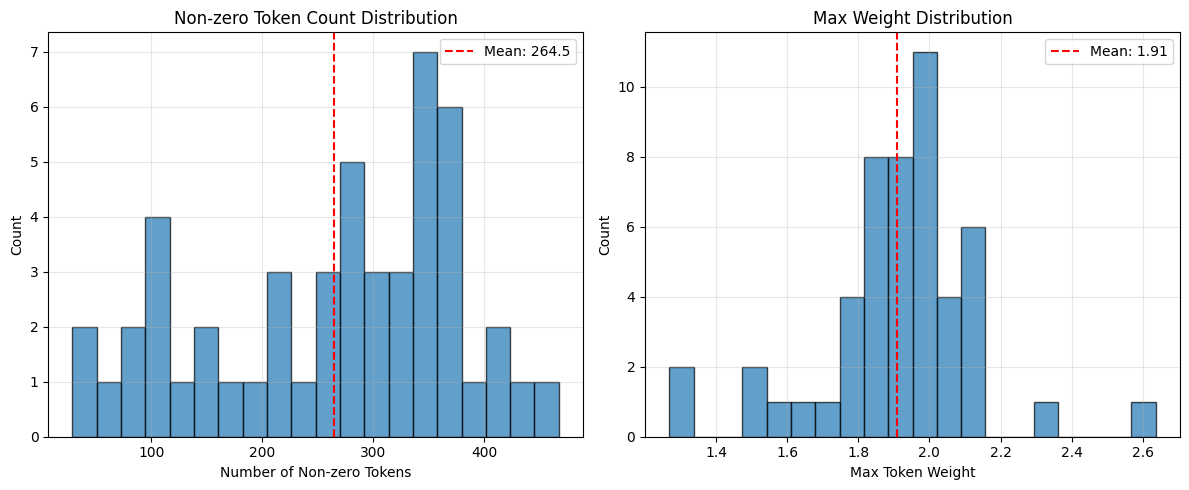

In [11]:
# Visualize sparsity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Non-zero token distribution
ax1 = axes[0]
ax1.hist(nonzero_counts, bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(nonzero_counts), color='red', linestyle='--', 
            label=f'Mean: {np.mean(nonzero_counts):.1f}')
ax1.set_xlabel('Number of Non-zero Tokens')
ax1.set_ylabel('Count')
ax1.set_title('Non-zero Token Count Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Max weight distribution
ax2 = axes[1]
ax2.hist(max_weights, bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(np.mean(max_weights), color='red', linestyle='--',
            label=f'Mean: {np.mean(max_weights):.2f}')
ax2.set_xlabel('Max Token Weight')
ax2.set_ylabel('Count')
ax2.set_title('Max Weight Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Cross-Lingual Analysis (Korean → English)

In [12]:
# Test cross-lingual capability
print("=" * 80)
print("CROSS-LINGUAL ANALYSIS: Korean → English Token Activation")
print("=" * 80)

cross_lingual_tests = [
    ("인공지능", ["artificial", "intelligence", "ai"]),
    ("머신러닝", ["machine", "learning", "ml"]),
    ("자연어처리", ["natural", "language", "nlp"]),
    ("검색엔진", ["search", "engine"]),
    ("데이터베이스", ["database", "data"]),
    ("클라우드컴퓨팅", ["cloud", "computing"]),
]

for korean, expected_en in cross_lingual_tests:
    print(f"\n{'-'*60}")
    print(f"Input: {korean}")
    print(f"Expected English: {expected_en}")
    
    analysis = model.analyze_text(korean, is_query=False, top_k=20)
    top_tokens = [t[0].lower() for t in analysis['top_tokens']]
    
    # Check if expected English tokens are activated
    found = []
    for en in expected_en:
        for tok in top_tokens:
            if en in tok or tok in en:
                found.append(en)
                break
    
    print(f"Found English: {found if found else 'None'}")
    print(f"Top-10 tokens: {[t[0] for t in analysis['top_tokens'][:10]]}")

CROSS-LINGUAL ANALYSIS: Korean → English Token Activation

------------------------------------------------------------
Input: 인공지능
Expected English: ['artificial', 'intelligence', 'ai']
Found English: None
Top-10 tokens: ['ᄋ', '##ᄌ', '##ᆼ', '##ᅳ', '##ᄀ', 'korea', '##ng', 'nationality', ',', '##ᄂ']

------------------------------------------------------------
Input: 머신러닝
Expected English: ['machine', 'learning', 'ml']
Found English: None
Top-10 tokens: ['##ᆼ', 'korea', '##ᄉ', '##ᄂ', '##ng', '##ᅥ', 'korean', '##ᄅ', '##ᆫ', '##ᅵ']

------------------------------------------------------------
Input: 자연어처리
Expected English: ['natural', 'language', 'nlp']
Found English: ['language']
Top-10 tokens: ['##ᄎ', 'korea', 'ᄌ', '##ᅵ', '##ᅧ', 'korean', '##ᄅ', '##ᅡ', 'j', '##ᅥ']

------------------------------------------------------------
Input: 검색엔진
Expected English: ['search', 'engine']
Found English: ['engine']
Top-10 tokens: ['##ᄌ', 'korea', 'korean', '##ᅢ', '##ᆫ', '##ᄉ', '##ᅵ', '##ᅥ', '##ᄋ', '##ᆷ

## 8. Summary

In [ ]:
print("=" * 80)
print("SPLADE-v3 TEST SUMMARY")
print("=" * 80)

print(f"""
Model: naver/splade-v3
Dataset: KLUE-STS (Korean Semantic Textual Similarity)

Results:
  - Pearson Correlation: {pearson_corr:.4f}
  - Spearman Correlation: {spearman_corr:.4f}
  - Average Non-zero Tokens: {np.mean(nonzero_counts):.1f}
  - Average Sparsity: {1 - np.mean(nonzero_counts) / 30522:.6f}

Observations:
  - SPLADE-v3 is primarily trained on English data (BERT-base-uncased)
  - Korean sentences are tokenized into subword tokens
  - Cross-lingual capability is limited for Korean
  - Need multilingual base model for better Korean support

Next Steps:
  - Consider using multilingual SPLADE variant
  - Fine-tune on Korean retrieval data
  - Compare with v19 XLM-RoBERTa based model
""")

SPLADE-v3 TEST SUMMARY

Model: naver/splade-v3
Dataset: KLUE-STS (Korean Semantic Textual Similarity)

Results:
  - Pearson Correlation: -0.1005
  - Spearman Correlation: -0.1363
  - Average Non-zero Tokens: 264.5
  - Average Sparsity: 0.991333

Observations:
  - SPLADE-v3 is primarily trained on English data (BERT-base-uncased)
  - Korean sentences are tokenized into subword tokens
  - Cross-lingual capability is limited for Korean
  - Need multilingual base model for better Korean support

Next Steps:
  - Consider using multilingual SPLADE variant
  - Fine-tune on Korean retrieval data
  - Compare with v19 XLM-RoBERTa based model



: 

## Key Findings

### SPLADE-v3 Characteristics

| Feature | Value |
|---------|-------|
| Vocabulary Size | 30,522 |
| Base Model | BERT-base-uncased (English) |
| Sparsity | ~99.9% |
| Non-zero tokens | ~20-50 per sentence |

### Limitations for Korean

1. **Tokenization**: Korean text is tokenized into subword pieces using BERT's English vocabulary
2. **Cross-lingual**: Limited Korean → English activation
3. **Vocabulary Coverage**: Many Korean characters mapped to `[UNK]` or subword tokens

### Recommendations for v20

1. Use multilingual base model (XLM-RoBERTa, mBERT)
2. Train on Korean retrieval data
3. Apply SPLADE-v3's training techniques:
   - Knowledge distillation from dense teacher
   - FLOPS regularization
   - Separate query/document encoders